In [86]:
import  numpy as np
import  collections
import os
import sys
import inspect
import time
from datetime import datetime
import random
import pickle
import reader
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [87]:
sess = tf.InteractiveSession()

In [39]:
data_path = 'data/'

# Displaying word ids and sentences for the first 10 samples in the validation set

In [91]:
import reader

v = reader._read_words("data/ptb.valid.txt")

train_data, valid_data, test_data, vocabulary = reader.ptb_raw_data("data/")

x, y = reader.ptb_producer(valid_data,10,5)

count = 0
word = 0
sentence = ''
ids = []
# First 10 sentences
while count<10:
    end = v[word]
    word_id = valid_data[word]
    if end == '<eos>':
        count += 1
        print('"'+sentence.strip()+'" '+str(ids)+'\n')
        sentence = ''
        ids = []
    else:
        sentence += end + ' '
        ids.append(word_id)
    word += 1

"consumers may want to move their telephones a little closer to the tv set" [1132, 93, 358, 5, 329, 51, 9836, 6, 326, 2476, 5, 0, 662, 388]

"<unk> <unk> watching abc 's monday night football can now vote during <unk> for the greatest play in N years from among four or five <unk> <unk>" [1, 1, 2974, 2158, 9, 381, 1068, 2347, 89, 99, 847, 198, 1, 11, 0, 3383, 1119, 7, 3, 72, 20, 211, 346, 36, 258, 1, 1]

"two weeks ago viewers of several nbc <unk> consumer segments started calling a N number for advice on various <unk> issues" [75, 422, 195, 3917, 4, 249, 1795, 1, 580, 3528, 892, 2374, 6, 3, 297, 11, 2709, 16, 1186, 1, 250]

"and the new syndicated reality show hard copy records viewers ' opinions for possible airing on the next day 's show" [8, 0, 35, 9922, 3747, 464, 710, 2998, 2037, 3917, 134, 6145, 11, 494, 5894, 16, 0, 130, 272, 9, 464]

"interactive telephone technology has taken a new leap in <unk> and television programmers are racing to exploit the possibilities" [9958, 732, 50

In [27]:
print('train: ',len(train_data))
print('val: ', len(valid_data))
print('test: ', len(test_data))


train:  929589
val:  73760
test:  82430


In [48]:
# Save dictionaries
import reader
train_data, valid_data, test_data, word_to_id = reader.ptb_raw_data("data/")
with open('word_to_id.pickle', 'wb') as handle:
    pickle.dump(word_to_id, handle)


In [8]:
class  config(object):
    vocab_size = vocab_size
    batch_size = 20
    num_steps = 20  # sequence length
    hidden_size = 200  # number of hidden units in LSTM
    keep_prob = 0.5  # 1 - dropoff rate
    num_layers = 2  # number of LSTM layers
    max_grad_norm = 5  # max gradient 
    init_scale = 0.1  # the initial scale of the weights
    max_epoch = 4  # the number of epochs trained with the initial learning rate
    max_max_epoch = 13  # the total number of epochs for training
    learning_rate = 1.0  # the initial value of the learning rate
    lr_decay = 0.5  # the decay of the learning rate for each epoch after "max_epoch"


In [9]:
batch_size = config.batch_size
num_steps = config.num_steps

In [10]:
raw_data = train_data

data_len = len(raw_data)
batch_len = data_len // batch_size

data_len, batch_len

(887521, 44376)

In [11]:
data = np.array(raw_data[0:batch_size * batch_len]).reshape(batch_size, batch_len)
data.shape

(20, 44376)

In [12]:
epoch_size  = (batch_len - 1) // num_steps
epoch_size

2218

In [13]:
i  =  0

x  =  tf.strided_slice(data, [0, i * num_steps], [batch_size, (i + 1) * num_steps])
y = tf.strided_slice(data, [0, i * num_steps + 1], [batch_size, (i + 1) * num_steps + 1])

x = x.eval()
y = y.eval()

x.shape, y.shape

((20, 20), (20, 20))

In [14]:
assert np.array_equal(x, data[0:batch_size:1, i * num_steps:(i + 1) * num_steps:1])
assert np.array_equal(y, data[0:batch_size:1, i * num_steps + 1:(i + 1) * num_steps + 1:1])

In [17]:
class PTBInput(object):
    """The input data."""

    def __init__(self, config, data, name=None):
        self.batch_size = batch_size = config.batch_size
        self.num_steps = num_steps = config.num_steps
        self.epoch_size = ((len(data) // batch_size) - 1) // num_steps
        
     
        self.input_data, self.targets = reader.ptb_producer(
            data, batch_size, num_steps, name=name)

In [18]:
class PTBModel(object):
    """The PTB model."""

    def __init__(self, is_training, config, input_=None):
        batch_size = config.batch_size
        num_steps = config.num_steps
        hidden_size = config.hidden_size
        vocab_size = config.vocab_size
        
        if input_ is not None:
            # For normal training and validation
            self._input = input_
            self._input_data = input_.input_data
            self._targets = input_.targets
            
        else:
            # For text generations
            self._input_data = tf.placeholder(tf.int32, [batch_size, num_steps])
            self._targets = tf.placeholder(tf.int32, [batch_size, num_steps])

        def lstm_cell():
          
            
            if 'reuse' in inspect.getargspec(
                    tf.contrib.rnn.BasicLSTMCell.__init__).args:
                return tf.contrib.rnn.BasicLSTMCell(
                    hidden_size,
                    forget_bias=0.0,
                    state_is_tuple=True,
                    reuse=tf.get_variable_scope().reuse)
            else:
                return tf.contrib.rnn.BasicLSTMCell(
                    hidden_size,
                    forget_bias=0.0,
                    state_is_tuple=True)
            
         
        attn_cell = lstm_cell

        # Implement dropoff (for training only)
        if is_training and config.keep_prob < 1:

            def attn_cell():
                return tf.contrib.rnn.DropoutWrapper(
                    lstm_cell(), output_keep_prob=config.keep_prob)

       
        attn_cells = [attn_cell() for _ in range(config.num_layers)]
        stacked_lstm = tf.contrib.rnn.MultiRNNCell(attn_cells, state_is_tuple=True)
        
  
         
        self._initial_state = stacked_lstm.zero_state(batch_size, tf.float32)
        
       
        with tf.device("/cpu:0"):
            embedding = tf.get_variable(
                "embedding", [vocab_size, hidden_size], dtype=tf.float32)
            input_embeddings = tf.nn.embedding_lookup(embedding, self.input_data)
       
        if is_training and config.keep_prob < 1:
            input_embeddings = tf.nn.dropout(input_embeddings, config.keep_prob)

    
        outputs = []
        state = self._initial_state
        
        with tf.variable_scope("RNN"):
            for time_step in range(num_steps):
                if time_step > 0:
                    tf.get_variable_scope().reuse_variables()
                
                (cell_output, state) = stacked_lstm(input_embeddings[:, time_step, :], state)
                outputs.append(cell_output)
            
        output = tf.reshape(tf.stack(axis=1, values=outputs), [-1, hidden_size])
        
        # Compute logits
        softmax_w = tf.get_variable(
            "softmax_w", [hidden_size, vocab_size], dtype=tf.float32)
        softmax_b = tf.get_variable(
            "softmax_b", [vocab_size], dtype=tf.float32)
        
        self._logits = logits = tf.matmul(output, softmax_w) + softmax_b
       
        self._logits_sample = tf.multinomial(logits, 1)
        
        # Instead of sampling, return the position with the largest logit
        self._logits_max = tf.argmax(logits, 1)
        
        # Reshape logits to be 3-D tensor for sequence loss
        logits = tf.reshape(logits, [batch_size, num_steps, vocab_size])

      
        loss = tf.contrib.seq2seq.sequence_loss(
            logits,  # shape: [batch_size, num_steps, vocab_size]
            self._targets,  # shape: [batch_size, num_steps]
            tf.ones([batch_size, num_steps], dtype=tf.float32),
            average_across_timesteps=False,
            average_across_batch=True)

        # Update the cost variables
        self._cost = cost = tf.reduce_sum(loss)
        self._final_state = state

        if not is_training:
            return

        # Optimizer
        self._lr = tf.Variable(0.0, trainable=False)
        
        tvars = tf.trainable_variables()
        grads, _ = tf.clip_by_global_norm(
            tf.gradients(cost, tvars), config.max_grad_norm)
        
        optimizer = tf.train.GradientDescentOptimizer(self._lr)
        self._train_op = optimizer.apply_gradients(
            zip(grads, tvars),
            global_step=tf.contrib.framework.get_or_create_global_step())

        self._new_lr = tf.placeholder(
            tf.float32, shape=[], name="new_learning_rate")
        self._lr_update = tf.assign(self._lr, self._new_lr)
        
        
    # To update learning rate
    def assign_lr(self, session, lr_value):
        session.run(self._lr_update, feed_dict={self._new_lr: lr_value})
    
    @property
    def input(self):
        return self._input
    
    @property
    def input_data(self):
        return self._input_data
    
    @property
    def targets(self):
        return self._targets

    @property
    def initial_state(self):
        return self._initial_state

    @property
    def cost(self):
        return self._cost

    @property
    def final_state(self):
        return self._final_state

    @property
    def lr(self):
        return self._lr

    @property
    def train_op(self):
        return self._train_op
    
    @property
    def logits_sample(self):
        return self._logits_sample
    
    @property
    def logits_max(self):
        return self._logits_max
    
    @property
    def logits(self):
        return self._logits

In [19]:
def run_epoch(session, model, eval_op=None, verbose=False):
    start_time = time.time()
    costs = 0.0
    iters = 0
    state = session.run(model.initial_state)
    fetches = {
        "cost": model.cost,
        "final_state": model.final_state,
    }
    
    if eval_op is not None:
        fetches["eval_op"] = eval_op
    
   
    for step in range(model.input.epoch_size):
        feed_dict = {}
        
      
        for i, (c, h) in enumerate(model.initial_state):
            feed_dict[c] = state[i].c
            feed_dict[h] = state[i].h
        
        vals = session.run(fetches, feed_dict)
        
     
        cost = vals["cost"]
        state = vals["final_state"]
        
      
        costs += cost
        iters += model.input.num_steps

        if verbose and step % (model.input.epoch_size // 10) == 10:
            print("%.3f (raw step: %.0f) perplexity: %.3f speed: %.0f wps" %
                  (step * 1.0 / model.input.epoch_size,
                   step,
                   np.exp(costs / iters),
                   iters * model.input.batch_size / (time.time() - start_time)))
            

    return np.exp(costs / iters)

In [20]:
feed = np.array(word_to_id['a']).reshape(1, 1)

In [21]:
text_length = 20

In [22]:
def generate_text(session, model, feed, text_length):
    state = session.run(model.initial_state)
    fetches = {
        "final_state": model.final_state,
        "logits": model.logits_sample
    }
    
    generated_text = [feed]
    
    for i in range(text_length):
        feed_dict = {}
        feed_dict[model.input_data] = feed
        
        for i, (c, h) in enumerate(model.initial_state):
            feed_dict[c] = state[i].c
            feed_dict[h] = state[i].h
        
        vals = session.run(fetches, feed_dict)
        

        state = vals["final_state"]
        feed = vals["logits"]
        
    
        generated_text.append(feed)

    return generated_text

In [23]:
save_path = 'model_output' + '_' + datetime.now().strftime('%Y-%m-%d-%H-%M')
save_path2 = 'assignment2/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [24]:
train_valid_config = config()

eval_config = config()
eval_config.batch_size = 1
eval_config.num_steps = 1

In [25]:
orig_stdout = sys.stdout

with tf.Graph().as_default():
    initializer = tf.random_uniform_initializer(-config.init_scale, config.init_scale)

    with tf.name_scope("Train"):
        train_input = PTBInput(config=train_valid_config, data=train_data, name="TrainInput")
        with tf.variable_scope("Model", reuse=None, initializer=initializer):
            m = PTBModel(is_training=True, config=config, input_=train_input)
        tf.summary.scalar("Training_Loss", m.cost)
        tf.summary.scalar("Learning_Rate", m.lr)

    with tf.name_scope("Valid"):
        valid_input = PTBInput(config=train_valid_config, data=valid_data, name="ValidInput")
        with tf.variable_scope("Model", reuse=True, initializer=initializer):
            mvalid = PTBModel(is_training=False, config=config, input_=valid_input)
        tf.summary.scalar("Validation_Loss", mvalid.cost)
    
    with tf.name_scope("Test"):
        test_input = PTBInput(config=eval_config, data=test_data, name="TestInput")
        with tf.variable_scope("Model", reuse=True, initializer=initializer):
            mtest = PTBModel(is_training=False, config=eval_config, input_=test_input)
    

    with tf.name_scope("Feed"):
        with tf.variable_scope("Model", reuse=True, initializer=initializer):
            mfeed = PTBModel(is_training=False, config=eval_config)
            
    sv = tf.train.Supervisor(logdir=save_path)
    with sv.managed_session() as session:
        for i in range(config.max_max_epoch):
            
            log_file_path = 'log_file_' + str(i) + '.txt'
            f = open(os.path.join(save_path, log_file_path), 'w')
            sys.stdout = f
            
            
            lr_decay = config.lr_decay**max(i + 1 - config.max_epoch, 0.0)
            m.assign_lr(session, config.learning_rate * lr_decay)
            print("Epoch: %d Learning rate: %.3f" % (i + 1, session.run(m.lr)))
            
   
            train_perplexity = run_epoch(session, m, eval_op=m.train_op, verbose=True)
            print("Epoch: %d Train Perplexity: %.3f" % (i + 1, train_perplexity))
            
            valid_perplexity = run_epoch(session, mvalid)
            print("Epoch: %d Valid Perplexity: %.3f" % (i + 1, valid_perplexity))
            
           
            generated_text = generate_text(session, mfeed, np.array(feed).reshape(1, 1), text_length)
            generated_text = ' '.join([id_to_word[text[0, 0]] for text in generated_text])
            print("Sample text generation:", generated_text)
            
            f.close()
            
        
        log_file_path = 'log_file_test_perplexity.txt'
        f = open(os.path.join(save_path, log_file_path), 'w')
        sys.stdout = f

        test_perplexity = run_epoch(session, mtest)
        print("Test Perplexity: %.3f" % test_perplexity)
        
        print("Saving model to %s." % save_path2)
        sv.saver.save(session, save_path2, global_step=sv.global_step)
        
        f.close()


sys.stdout = orig_stdout

C:\Users\preet\Anaconda3\envs\cs231n\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead


Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path model_output_2018-05-29-21-49\model.ckpt
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:Model/global_step/sec: 0
INFO:tensorflow:Recording summary at step 0.
INFO:tensorflow:Recording summary at step 1295.
INFO:tensorflow:Model/global_step/sec: 11.0151
INFO:tensorflow:Recording summary at step 2531.
INFO:tensorflow:Model/global_step/sec: 10.3341
INFO:tensorflow:Recording summary at step 4210.
INFO:tensorflow:Model/global_step/sec: 13.9815
INFO:tensorflow:Recording summary at step 5806.
INFO:tensorflow:Model/global_step/sec: 13.2597
INFO:tensorflow:Saving checkpoint to path model_output_2018-05-29-21-49\model.ckpt
INFO:tensorflow:Recording summary at step 73

# Plotting training and validation losses with respect to epochs

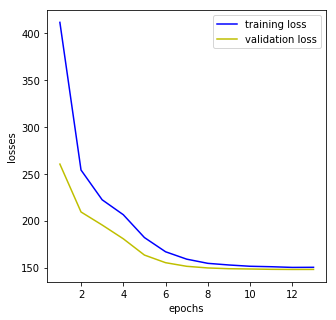

In [92]:
import matplotlib.pyplot as plt
#Obtained losses from the saved model log
epochs = np.arange(1,16)
training_loss = np.array([411.878,254.151,222.337,206.397,181.998,166.810,158.918,154.449,152.692,151.322,150.832,150.105,150.222])
validation_loss = np.array([260.459,209.322,195.402,180.682,163.290,155.147,151.287,149.529,148.718,148.415,148.064,147.929,147.959])
plt.figure(figsize=(5,5))
plt.plot(epoch,training_loss,color='b',label='training loss')
plt.plot(epoch,validation_loss,color='y',label='validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('losses')
plt.show()